In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
np.random.seed(2)

## Load the Data

In [5]:
data = np.loadtxt('data/data.txt').astype(int)
movies = np.genfromtxt('data/movies.txt', delimiter='\t', dtype=None,encoding=None, 
                       names=['Movie ID','Title','Unknown','Action','Adventure','Animation','Childrens','Comedy','Crime',
                             'Documentary','Drama','Fantasy','Film-Noir','Horror','Musical','Mystery','Romance','Sci-Fi',
                              'Thriller','War','Western'], deletechars='')

# Section 4

## All Movies

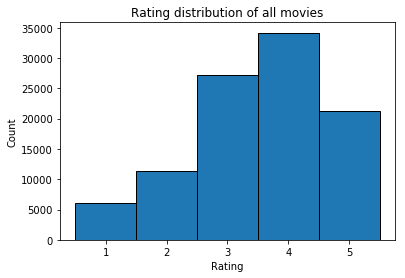

In [6]:
# plot distribution of all ratings
plt.hist(data[:,2],bins=np.arange(1,7)-0.5,edgecolor='k');
plt.xticks(np.arange(1,6));
plt.xlabel('Rating');
plt.ylabel('Count');
plt.title('Rating distribution of all movies');

## Popular Movies

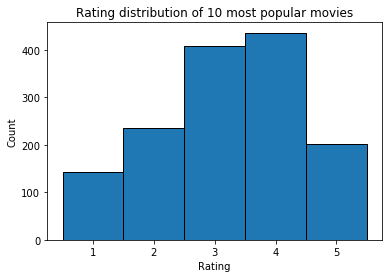

In [7]:
# count number of ratings per movie
r_counts = np.bincount(data[:,1])
# find movie indices with most ratings
pop_inds_mov = np.argpartition(r_counts,-10)[-10:]+1
# find data indices corresponding to top 10 movies
pop_inds_data = np.nonzero(np.isin(data[:,1], pop_inds_mov))

# thin data to that of top 10 movies
data_pop = data[pop_inds_data,:][0]

# plot distribution of these ratings
plt.hist(data_pop[:,2],bins=np.arange(1,7)-0.5,edgecolor='k');
plt.xticks(np.arange(1,6));
plt.xlabel('Rating');
plt.ylabel('Count');
plt.title('Rating distribution of 10 most popular movies');

# Highest Rated Movies

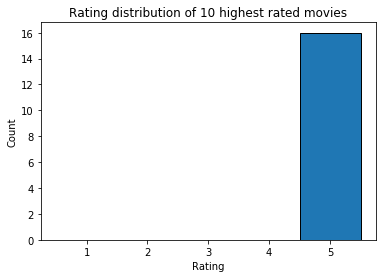

In [8]:
# calculate average rating per movie
r_aves = np.zeros(1682) 
for j in np.arange(0,1682):
    r_aves[j] = np.mean(data[np.where(data[:,1]==j+1),2])

# find movie indices with highest average rating
ave_inds_mov = np.argpartition(r_aves,-10)[-10:]+1
# find data indices with corresponding top 10 movies
ave_inds_data = np.nonzero(np.isin(data[:,1], ave_inds_mov))

# thin data to that of top 10 movies
data_ave = data[ave_inds_data,:][0]

# plot distribution of these ratings
plt.hist(data_ave[:,2],bins=np.arange(1,7)-0.5,edgecolor='k');
plt.xticks(np.arange(1,6));
plt.xlabel('Rating');
plt.ylabel('Count');
plt.title('Rating distribution of 10 highest rated movies');

## Movies by Genre

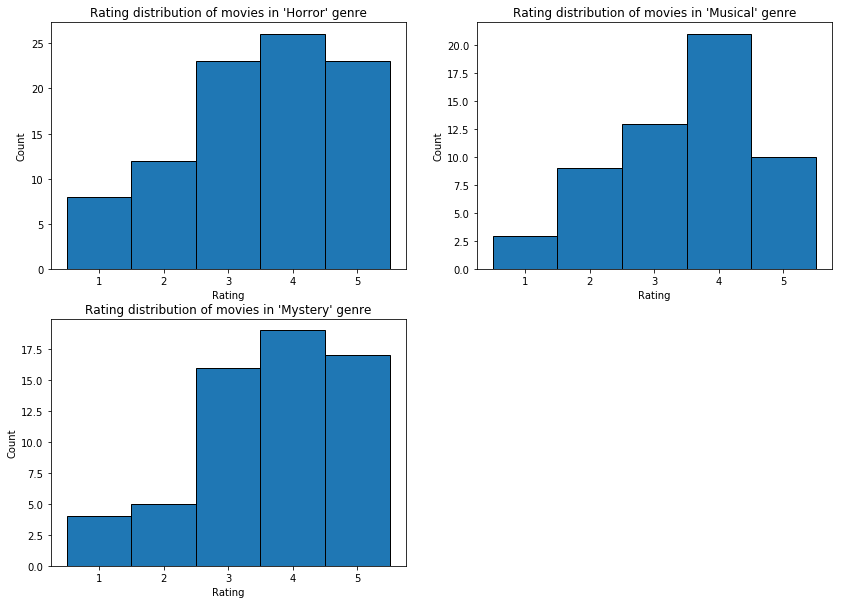

In [9]:
# Genres to compare
genres = ['Horror','Musical','Mystery']

plt.figure(figsize=(14,10))
for idx,val in enumerate(genres):
    g_inds_mov = np.array(np.where(movies[val]==1))[0]
    
    plt.subplot(2,2,idx+1)
    plt.hist(data[g_inds_mov,2],bins=np.arange(1,7)-0.5,edgecolor='k')
    plt.xticks(np.arange(1,6));
    plt.xlabel('Rating');
    plt.ylabel('Count');
    plt.title('Rating distribution of movies in \'%s\' genre'%val);

# Section 5

## Simple Factorization

In [11]:
# choice of optimizer: 'plain', 'bias' or 'oos'
optimization = 'bias'

Y_train = np.loadtxt('data/train.txt').astype(int)
Y_test = np.loadtxt('data/test.txt').astype(int)

M = max(max(Y_train[:,0]), max(Y_test[:,0])).astype(int) # users
N = movies.shape[0] # movies
    
if optimization == 'plain':
    from collab_0 import train_model, get_err

    print('Factorizing with plain model.')

    reg = 0.1
    eta = 0.03 # learning rate
    K = 20

    print("Training model with M = %s, N = %s, k = %s, eta = %s, reg = %s"%(M, N, K, eta, reg))
    U, V, err = train_model(M, N, K, eta, reg, Y_train)
    print('Factorization complete.')

elif optimization == 'bias':
    from collab_bias import train_model, get_err

    print('Factorizing with bias model.')

    reg = 0.1
    eta = 0.03 # learning rate
    K = 20

    print("Training model with M = %s, N = %s, k = %s, eta = %s, reg = %s"%(M, N, K, eta, reg))
    U, V, a, b, err = train_model(M, N, K, eta, reg, Y_train)
    print('Factorization complete.')
    
elif optimization == 'oos':
    # oos model using https://github.com/benfred/implicit
    """
    import implicit
    from scipy import sparse
    
    print('Factorizing with off-the-shelf model.')
    
    m = sparse.coo_matrix((Y_train[:,2].astype(np.float32),
                    (Y_train[:,1], Y_train[:,0])))
    
    model = implicit.als.AlternatingLeastSquares(factors=20)
    model.fit(m.tocsr())
    
    V = model.item_factors
    print('Factorization complete.')
    """
    
    
    # oos model using http://surprise.readthedocs.io/en/stable/matrix_factorization.html
    from surprise.prediction_algorithms.matrix_factorization import NMF
    from surprise import Dataset
    from surprise import Reader
    from surprise import accuracy
    
    reader = Reader(line_format='user item rating', sep='\t')
    model = NMF(n_factors=20)
    surprise_train = Dataset.load_from_file('data/data.txt', reader=reader)
    #surprise_test = Dataset.load_from_file('data/test.txt', reader=reader)
    model.fit(surprise_train.build_full_trainset())
    #predictions = model.test(surprise_test.build_full_trainset().build_testset())
    #err_test = accuracy.rmse(predictions)**2
    V = model.qi
    #print('Test error: %f' % err_test)
    
else:
    print('Invalid optimization method specified')
    

Factorizing with bias model.
Training model with M = 943, N = 1682, k = 20, eta = 0.03, reg = 0.1
Factorization complete.


## SVD and Projection

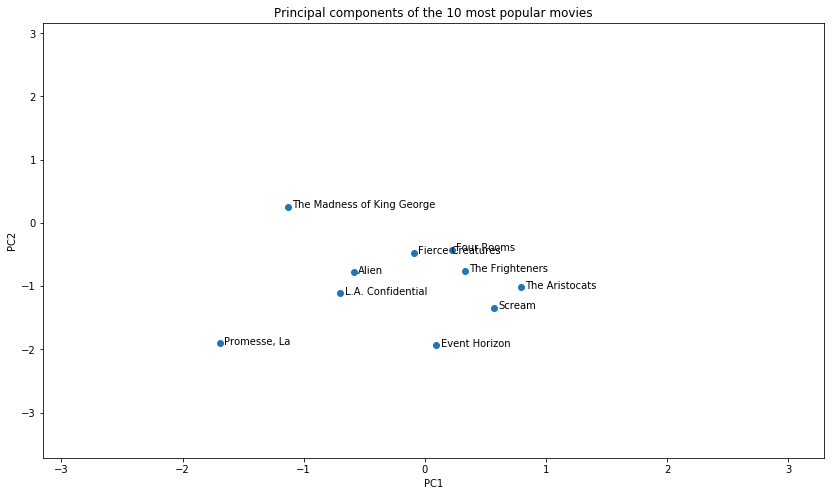

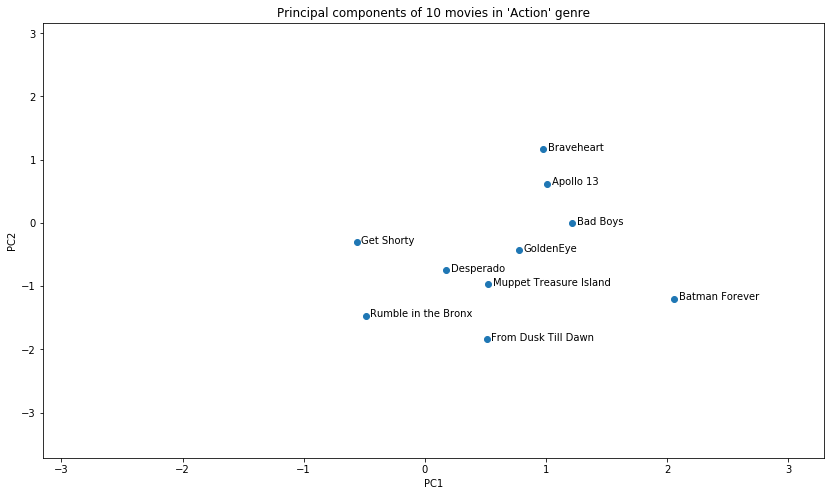

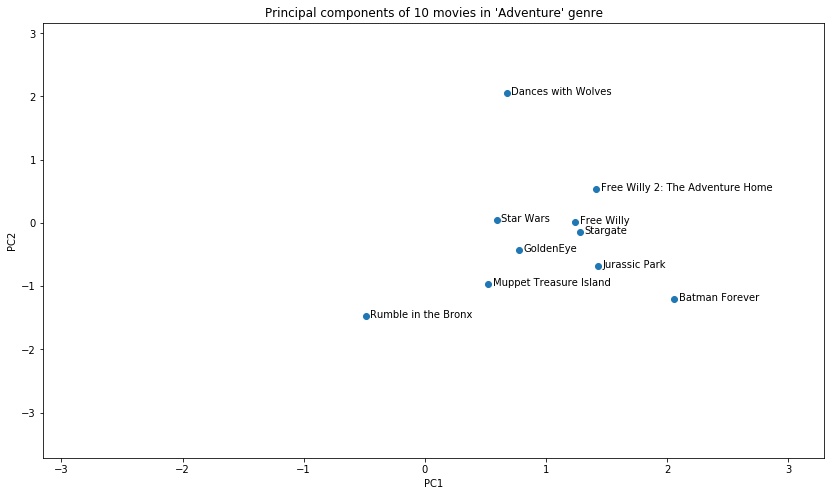

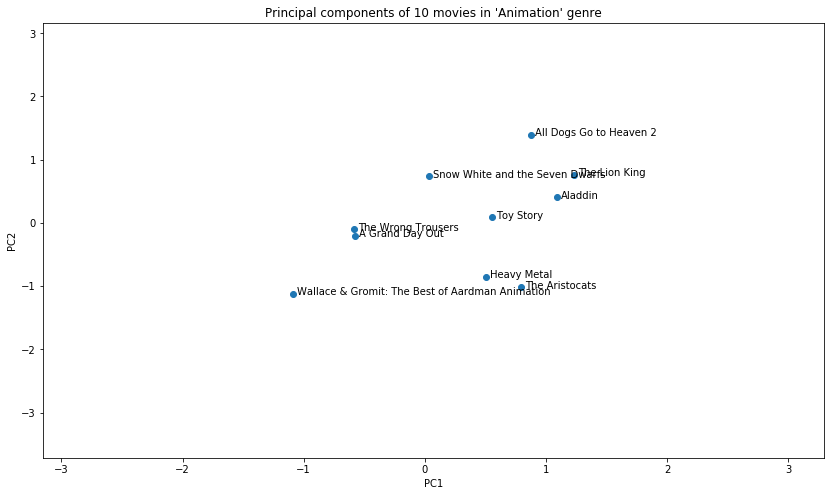

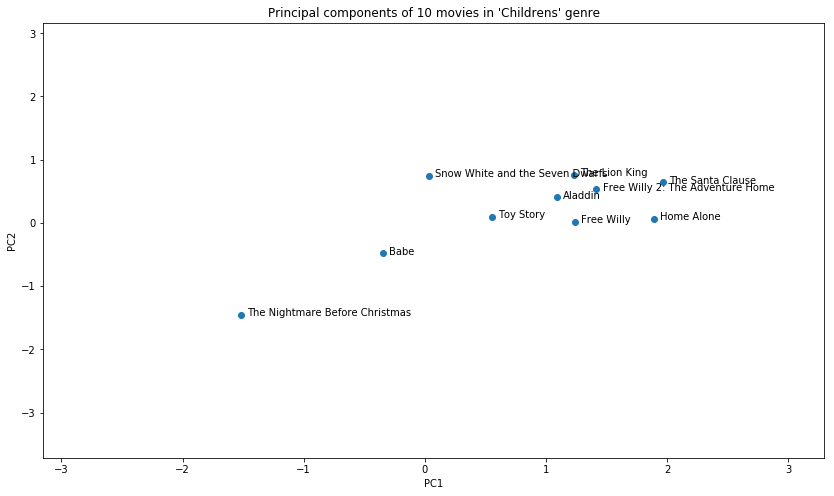

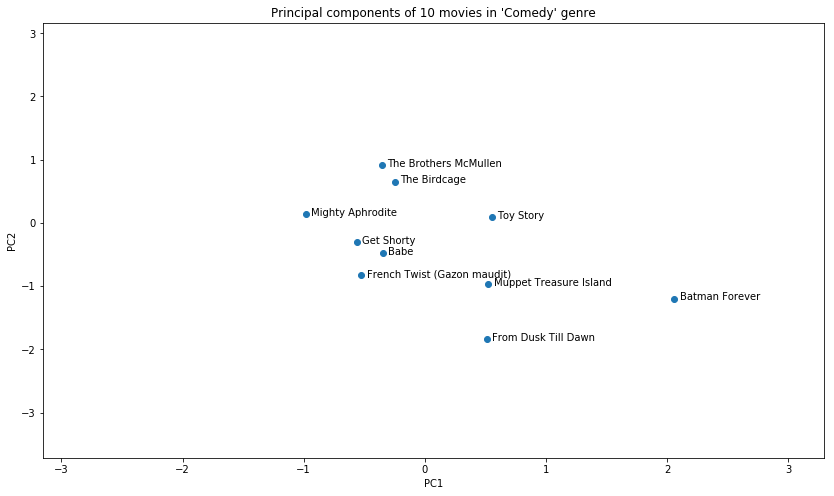

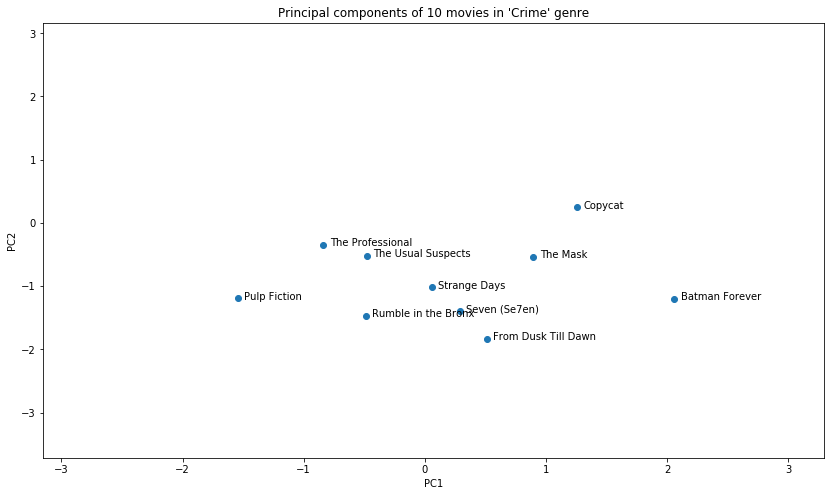

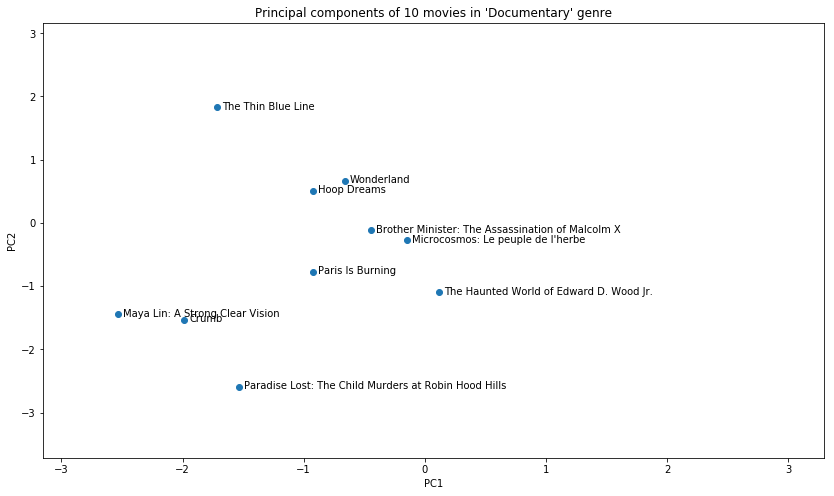

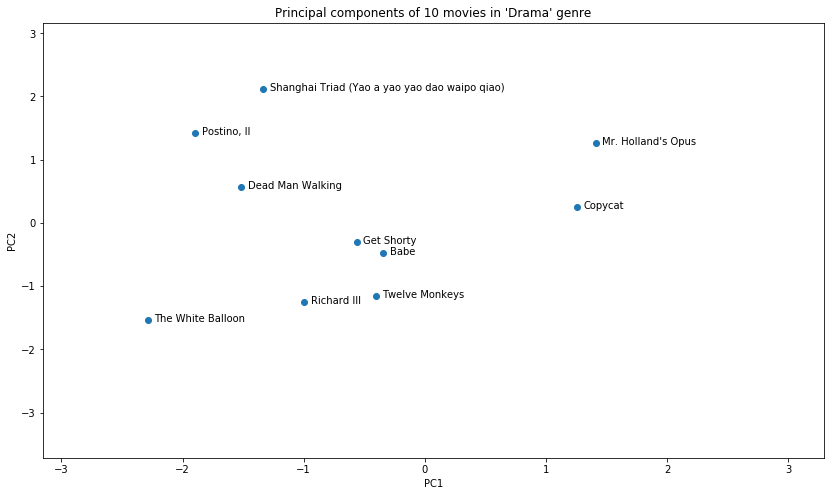

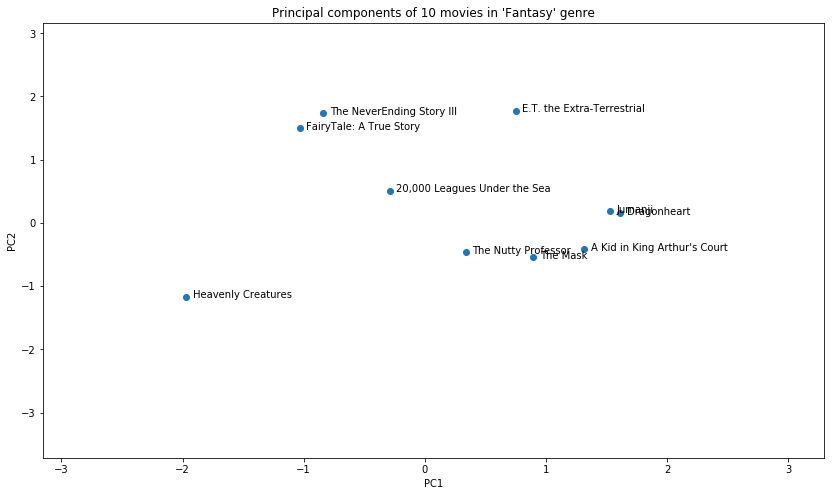

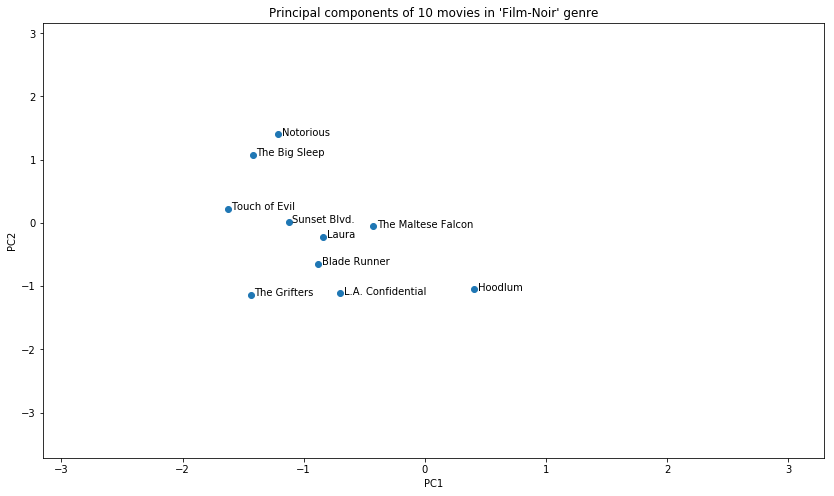

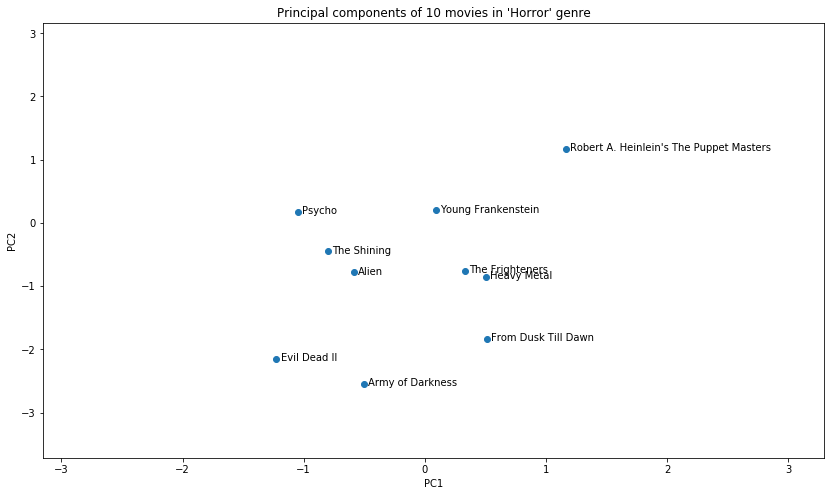

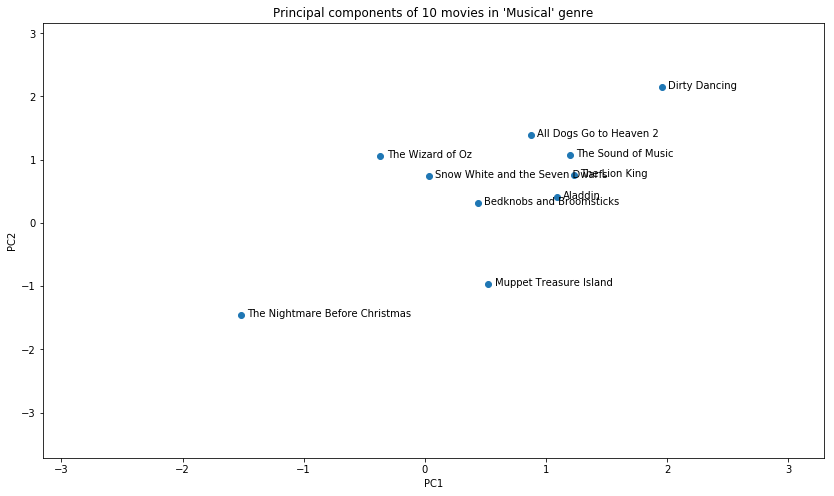

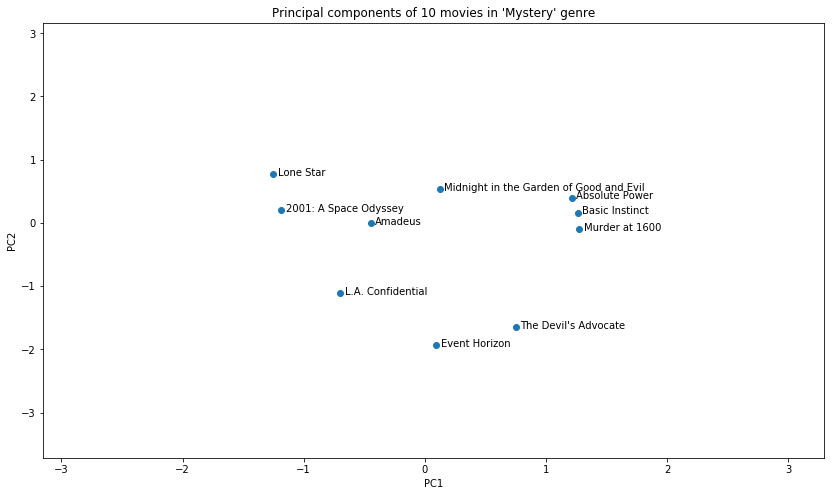

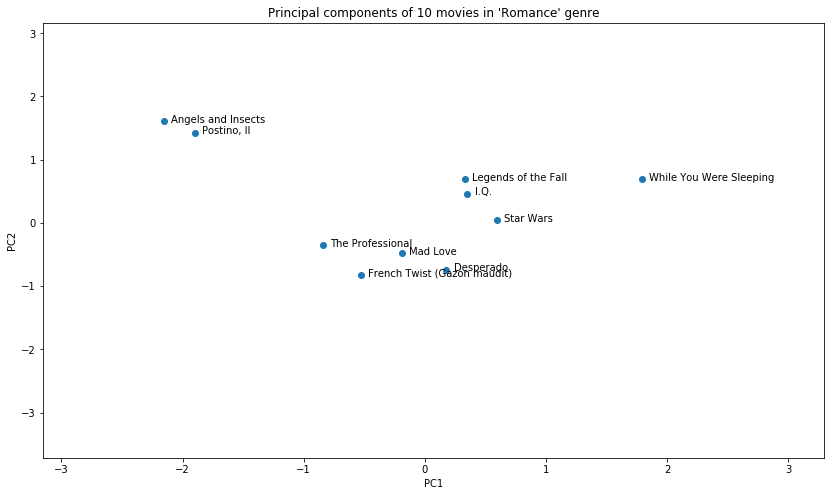

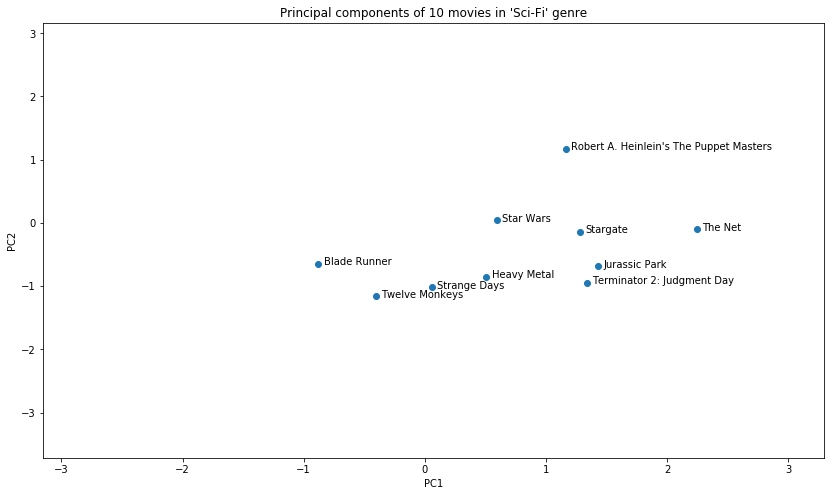

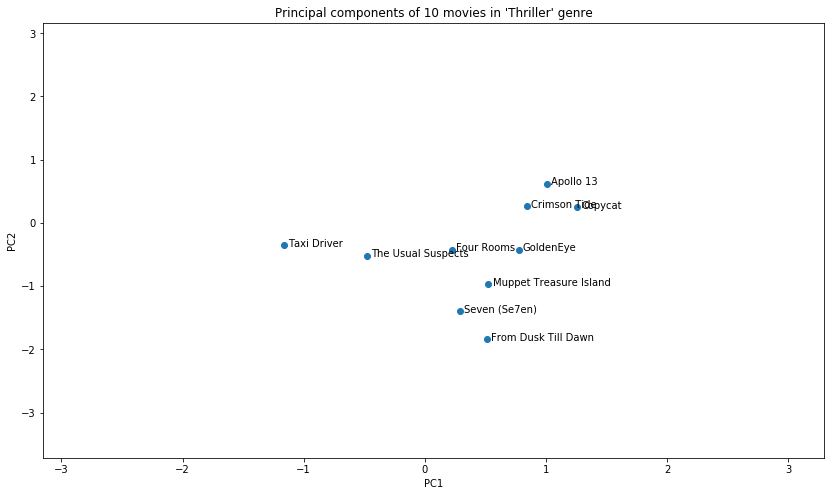

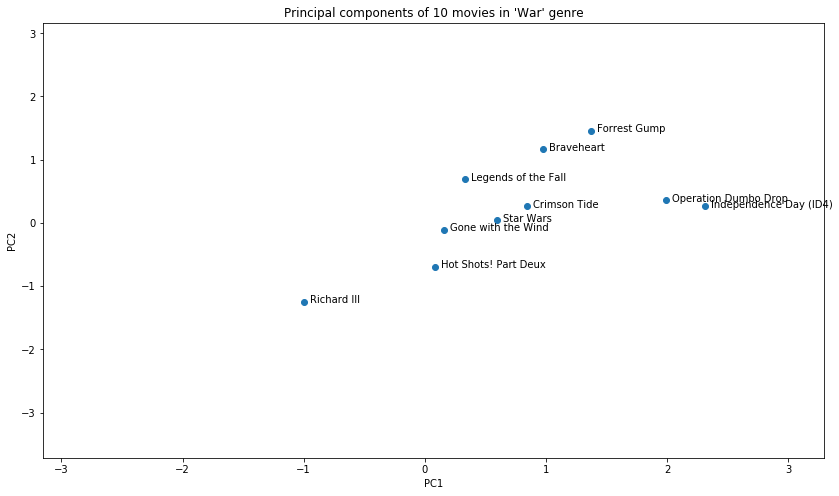

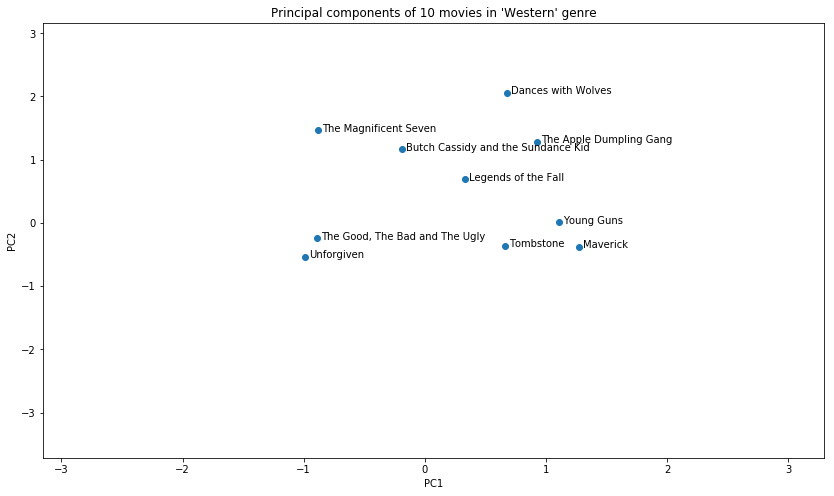

In [17]:
# number of movies to visualize
nmovies = 10

# Perform the SVD

# Following convention in the guide where V is KxN
V_centered = (V-np.tile(np.mean(V,axis=1),(V.shape[1],1)).T).T
u,s,vh = np.linalg.svd(V_centered, full_matrices=False)
VT = np.dot(u[:,0:2].T,V_centered)

# Normalize data for the plots
VT[0] = (VT[0] - np.mean(VT[0]))/np.std(VT[0])
VT[1] = (VT[1] - np.mean(VT[1]))/np.std(VT[1])

# Find the data range for the plots
ylim = [min(VT[1,:]),max(VT[1,:])]
xlim = [min(VT[0,:]),max(VT[0,:])]

## Popular movies
r_counts = np.bincount(data[:,1])
pop_inds_mov = np.argpartition(r_counts,-nmovies)[-nmovies:]+1
inds = pop_inds_mov[:nmovies]

fig,ax = plt.subplots(figsize=(14,8))
ax.scatter(VT[0,inds],VT[1,inds])
plt.title('Principal components of the %i most popular movies' % nmovies);
plt.xlabel('PC1');
plt.ylabel('PC2');
plt.ylim(ylim)
plt.xlim(xlim)

xrange = max(VT[0,inds])-min(VT[0,inds])
yrange = max(VT[1,inds])-min(VT[1,inds])
    
for j in inds:
    # Make titles consistent wrt "
    mtitle = movies[j][1].replace('"', '')[:-7]
    # Make the titles more readable
    if mtitle[-5:] == ', The':
        mtitle = 'The ' + mtitle[:-5]
    if mtitle[-3:] == ', A':
        mtitle = 'A ' + mtitle[:-3]
    ax.annotate(mtitle,(VT[0,j]+0.015*xrange,VT[1,j]-0.008*yrange))
        

## Movies by genre
genres = ['Action','Adventure','Animation','Childrens','Comedy','Crime',
                             'Documentary','Drama','Fantasy','Film-Noir','Horror','Musical','Mystery','Romance','Sci-Fi',
                              'Thriller','War','Western']

for idx,val in enumerate(genres):
    g_inds_mov = np.array(np.where(movies[val]==1))[0]
    inds = g_inds_mov[:nmovies]

    fig,ax = plt.subplots(figsize=(14,8))
    ax.scatter(VT[0,inds],VT[1,inds])
    plt.title('Principal components of %i movies in \'%s\' genre' % (nmovies,val));
    plt.xlabel('PC1');
    plt.ylabel('PC2');
    plt.ylim(ylim)
    plt.xlim(xlim)
    
    xrange = max(VT[0,inds])-min(VT[0,inds])
    yrange = max(VT[1,inds])-min(VT[1,inds])

    for j in inds:
        # Make titles consistent wrt "
        mtitle = movies[j][1].replace('"', '')[:-7]
        # Make the titles more readable
        if mtitle[-5:] == ', The':
            mtitle = 'The ' + mtitle[:-5]
        if mtitle[-3:] == ', A':
            mtitle = 'A ' + mtitle[:-3]
        ax.annotate(mtitle,(VT[0,j]+0.015*xrange,VT[1,j]-0.008*yrange))

(20, 20)

(1682, 20)